# Pre-Calculation of Sets

In [1]:
######################################################################
#                         IMPORT PACKAGES                            #
######################################################################
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import *
from matplotlib.collections import PatchCollection
import time
import random
from joblib import Parallel, delayed
import multiprocessing
import os
random.seed()

In [2]:
######################################################################
#                     PARAMETERS AND FUNCTIONS                       #
######################################################################

# Calculates if points s and t are visibile to each other
def Cvis(pt):
    s = [pt[0],pt[1]]
    t = [pt[2],pt[3]]
    result = Or([And((Or(O[i][0] == s[0],(bool(np.sign(t[0]-O[i][0]+np.sign(O[i][0]-s[0])) == np.sign(O[i][0]-s[0]))))),
                        Or(O[i][1] == s[1],(bool(np.sign(t[1]-O[i][1]+np.sign(O[i][1]-s[1])) == np.sign(O[i][1]-s[1])))))
                        for i in range(numobjects)])
    return is_true(simplify(Not(result)))

#OUTPUT PREFERENCES
makeplots = True
logicalsoutput = False
modeltoterminal = False
randomobjects = False
modeltxt = False
mapchoice = 'USC'
parallel = True

allow = 100#float('inf') #distance each camera can see, in pixels on image

if mapchoice == 'UCLA':
    UCLAmap = True
    USCmap = False
    ARLmap = False
    GTmap = False
    manualmap = False
    xgrid = 33
    ygrid = 25
    numobjects = 378
elif mapchoice == 'USC':
    UCLAmap = False
    USCmap = True
    ARLmap = False
    GTmap = False
    manualmap = False
    xgrid = 26
    ygrid = 21
    numobjects = 175
elif mapchoice == 'ARL':
    UCLAmap = False
    USCmap = False
    ARLmap = True
    GTmap = False
    manualmap = False
    xgrid = 31
    ygrid = 27
    numobjects = 246
elif mapchoice == 'GT': #may be a tad bit too large, consider cutting down
    UCLAmap = False
    USCmap = False
    ARLmap = False
    GTmap = True
    manualmap = False
    xgrid = 50
    ygrid = 51
    numobjects = 815
elif mapchoice == 'manual':
    UCLAmap = False
    USCmap = False
    ARLmap = False
    GTmap = False
    manualmap = True
    xgrid = 3
    ygrid = 3
    numobjects = 1

#Boolean grid, True where cameras are to be placed C[xpos][ypos] = T/F
C = [[Bool('C[%s][%s]' % (j,i)) for i in range(ygrid)] for j in range(xgrid)]

#OBJECT LOCATION IN GRID O[objectnumber][x=index 0, y = index 1]
O = [[Int('Obj%s_x' % i ), Int('Obj%s_y' % i)] for i in range(1,numobjects+1)]
#O = [[1,1]]


######################################################################
#                     DISTANCE CONSIDERATIONS                        #
######################################################################

#Edge weighting in each direction Costs[xpos][ypos] = [width, height]
#Costs = np.ones((xgrid,ygrid,2))
precalcstart = time.time()

#This chunk imports edge weights from UCLA map segment and formats them appropriately
Costs = np.empty((xgrid,ygrid,2))
if UCLAmap == True:
    xcosts = open('UCLAmapxcosts.txt',mode='r')
    ycosts = open('UCLAmapycosts.txt',mode='r')
    x = 0
    xvals = xcosts.readlines()
    yvals = ycosts.readlines()
    for i in xvals:
        y = 0
        xc = i.replace("\n","")
        for j in yvals:
            yc = j.replace("\n","")
            Costs[x,y,0] = float(xc)
            Costs[x,y,1] = float(yc)
            y += 1
        x += 1
    xcosts.close()
    ycosts.close()
elif USCmap == True:
    xcosts = open('USCmapxcosts.txt',mode='r')
    ycosts = open('USCmapycosts.txt',mode='r')
    x = 0
    xvals = xcosts.readlines()
    yvals = ycosts.readlines()
    for i in xvals:
        y = 0
        xc = i.replace("\n","")
        for j in yvals:
            yc = j.replace("\n","")
            Costs[x,y,0] = float(xc)
            Costs[x,y,1] = float(yc)
            y += 1
        x += 1
    xcosts.close()
    ycosts.close()
elif ARLmap == True:
    xcosts = open('ARLmapxcosts.txt',mode='r')
    ycosts = open('ARLmapycosts.txt',mode='r')
    x = 0
    xvals = xcosts.readlines()
    yvals = ycosts.readlines()
    for i in xvals:
        y = 0
        xc = i.replace("\n","")
        for j in yvals:
            yc = j.replace("\n","")
            Costs[x,y,0] = float(xc)
            Costs[x,y,1] = float(yc)
            y += 1
        x += 1
    xcosts.close()
    ycosts.close()
elif GTmap == True:
    xcosts = open('GTmapxcosts.txt',mode='r')
    ycosts = open('GTmapycosts.txt',mode='r')
    x = 0
    xvals = xcosts.readlines()
    yvals = ycosts.readlines()
    for i in xvals:
        y = 0
        xc = i.replace("\n","")
        for j in yvals:
            yc = j.replace("\n","")
            Costs[x,y,0] = float(xc)
            Costs[x,y,1] = float(yc)
            y += 1
        x += 1
    xcosts.close()
    ycosts.close()
elif manualmap == True:
    Costs = np.ones((xgrid,ygrid,2))

#this chunk imports object locations from UCLA map segment
if UCLAmap == True:
    randomobjects = False
    objlocs = open('UCLAmapobjects.txt',mode='r')
    locs = []
    for i in objlocs:
        loc = i.replace("\n","")
        loc = loc.split(",")
        locs.append(loc)
    locs = [[int(i[0]), int(i[1])] for i in locs]
    objlocs.close()
    O = locs
elif USCmap == True:
    randomobjects = False
    objlocs = open('USCmapobjects.txt',mode='r')
    locs = []
    for i in objlocs:
        loc = i.replace("\n","")
        loc = loc.split(",")
        locs.append(loc)
    locs = [[int(i[0]), int(i[1])] for i in locs]
    objlocs.close()
    O = locs
elif ARLmap == True:
    randomobjects = False
    objlocs = open('ARLmapobjects.txt',mode='r')
    locs = []
    for i in objlocs:
        loc = i.replace("\n","")
        loc = loc.split(",")
        locs.append(loc)
    locs = [[int(i[0]), int(i[1])] for i in locs]
    objlocs.close()
    O = locs
elif GTmap == True:
    randomobjects = False
    objlocs = open('GTmapobjects.txt',mode='r')
    locs = []
    for i in objlocs:
        loc = i.replace("\n","")
        loc = loc.split(",")
        locs.append(loc)
    locs = [[int(i[0]), int(i[1])] for i in locs]
    objlocs.close()
    O = locs
elif manualmap == True:
    O = [[1,1]]

locations = [] #generate list of all potential object locations (gridspace - object locations)
for i in range(xgrid):
	for j in range(ygrid):
		locations.append([i, j])
for o in range(numobjects): #select random option from list (if desired)
	if randomobjects == True:
		O[o] = random.choice(locations)
	locations.remove(O[o])	#remove selected option from list (no doubly placed objects)

Dists = np.ones([xgrid,ygrid,xgrid,ygrid])*np.inf #Start distances at infinity (so objects are not 'seeable')
for pt1 in range(len(locations)):
    for pt2 in range(pt1,len(locations)):
        x = sum(Costs[min(locations[pt1][0],locations[pt2][0]):max(locations[pt1][0],locations[pt2][0])+1,locations[pt1][1],0])
        y = sum(Costs[locations[pt1][0],min(locations[pt1][1],locations[pt2][1]):max(locations[pt1][1],locations[pt2][1])+1,1])
        Dists[locations[pt1][0],locations[pt1][1],locations[pt2][0],locations[pt2][1]] = max(x,y)
        Dists[locations[pt2][0],locations[pt2][1],locations[pt1][0],locations[pt1][1]] = max(x,y) #Abuse symmetry


######################################################################
#                    GENERATE VISIBLE SETS                           #
######################################################################
# Pull only the points that are within allow of each other
vis = np.transpose(np.nonzero(Dists <= allow))
vis = vis.tolist()
for el in vis:
    vis.remove([el[2],el[3],el[0],el[1]]) #Abuse symmetry
    
l = [[[] for i in range(ygrid)] for j in range(xgrid)]

# Create a list to pull elements from and condition on
# l[x][y] = pairs of points which are visible from (x,y)
# can be done in parallel if desired
if parallel == True:
    start = time.time()
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(Cvis)(i) for i in vis)
    #print('Parallel compute time:',np.floor((time.time() - start)/60) ,'minutes', (time.time() - start)%60 ,'seconds')
    for i, pt in enumerate(vis):
        pt1 = [pt[0],pt[1]]
        pt2 = [pt[2],pt[3]]
        if results[i]:
            l[pt[0]][pt[1]].append([pt[2],pt[3]])
            l[pt[2]][pt[3]].append([pt[0],pt[1]])
else:
    for pt in vis:
        if Cvis(pt):
            l[pt[0]][pt[1]].append([pt[2],pt[3]])
            l[pt[2]][pt[3]].append([pt[0],pt[1]])

# Output the precalculation/prep time for benchmark purposes
precalctime = time.time() - precalcstart
print('PRECALCULATION COMPLETED')
print('Total precalculation time:', np.floor(precalctime/60),'minutes', precalctime%60,'seconds')

PRECALCULATION COMPLETED
Total precalculation time: 1.0 minutes 24.348916053771973 seconds


# Solver Input

In [ ]:
######################################################################
#                     CONSTRAINT GENERATION                          #
######################################################################
constrstart = time.time()

numcams = 54#number of cameras to be used
coverlevel = 1 #number of cameras to cover each block

# Create a list of visibility constraints
# At each point (x,y), select at least coverlevel locations that are visible to (x,y)
visibility = []
for pt1 in locations:
    visibility.append(Sum([If(C[pt2[0]][pt2[1]],1,0) for pt2 in l[pt1[0]][pt1[1]]]) >= coverlevel)

# Limit the number of squares that can be True -- only use numcams cameras
camnumconstr = []
camnumconstr.append(Sum([If(C[pt[0]][pt[1]],1,0) for pt in locations]) == numcams)

# Do not select object locations to be camera locations
notobject = []
notobject.append(And([C[O[o][0]][O[o][1]] == False for o in range(numobjects)]))

# Output time generating constraints for benchmarking purposes
constrainttime = time.time() - constrstart
print('Constraint calculation time:', np.floor(constrainttime/60), 'm', constrainttime%60, 's')

######################################################################
#                          RUNNING SOLVER                            #
######################################################################
s = Solver()

solverstart = time.time()
s.add(notobject)
s.add(camnumconstr)
s.add(visibility)
satcheck = s.check()
solvertime = time.time() - solverstart
        
print('Solver runtime :', np.floor(solvertime/60), 'm', solvertime%60,'s')
print('Total time :', np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
print('SOLVER STATUS:',satcheck)

Constraint calculation time: 0.0 m 0.9234130382537842 s


# Plot Data


		PROBLEM: SATISFIABLE				    
Map: USC
Number of cameras: 55
Cover level: 1
Total computation time : 1.0 m 35.112359285354614 s
Pre-calculation time: 1.0 m 24.348916053771973 s
Constraint generation : 0.0 m 0.9195351600646973 s
Solver runtime : 0.0 m 9.843908071517944 s


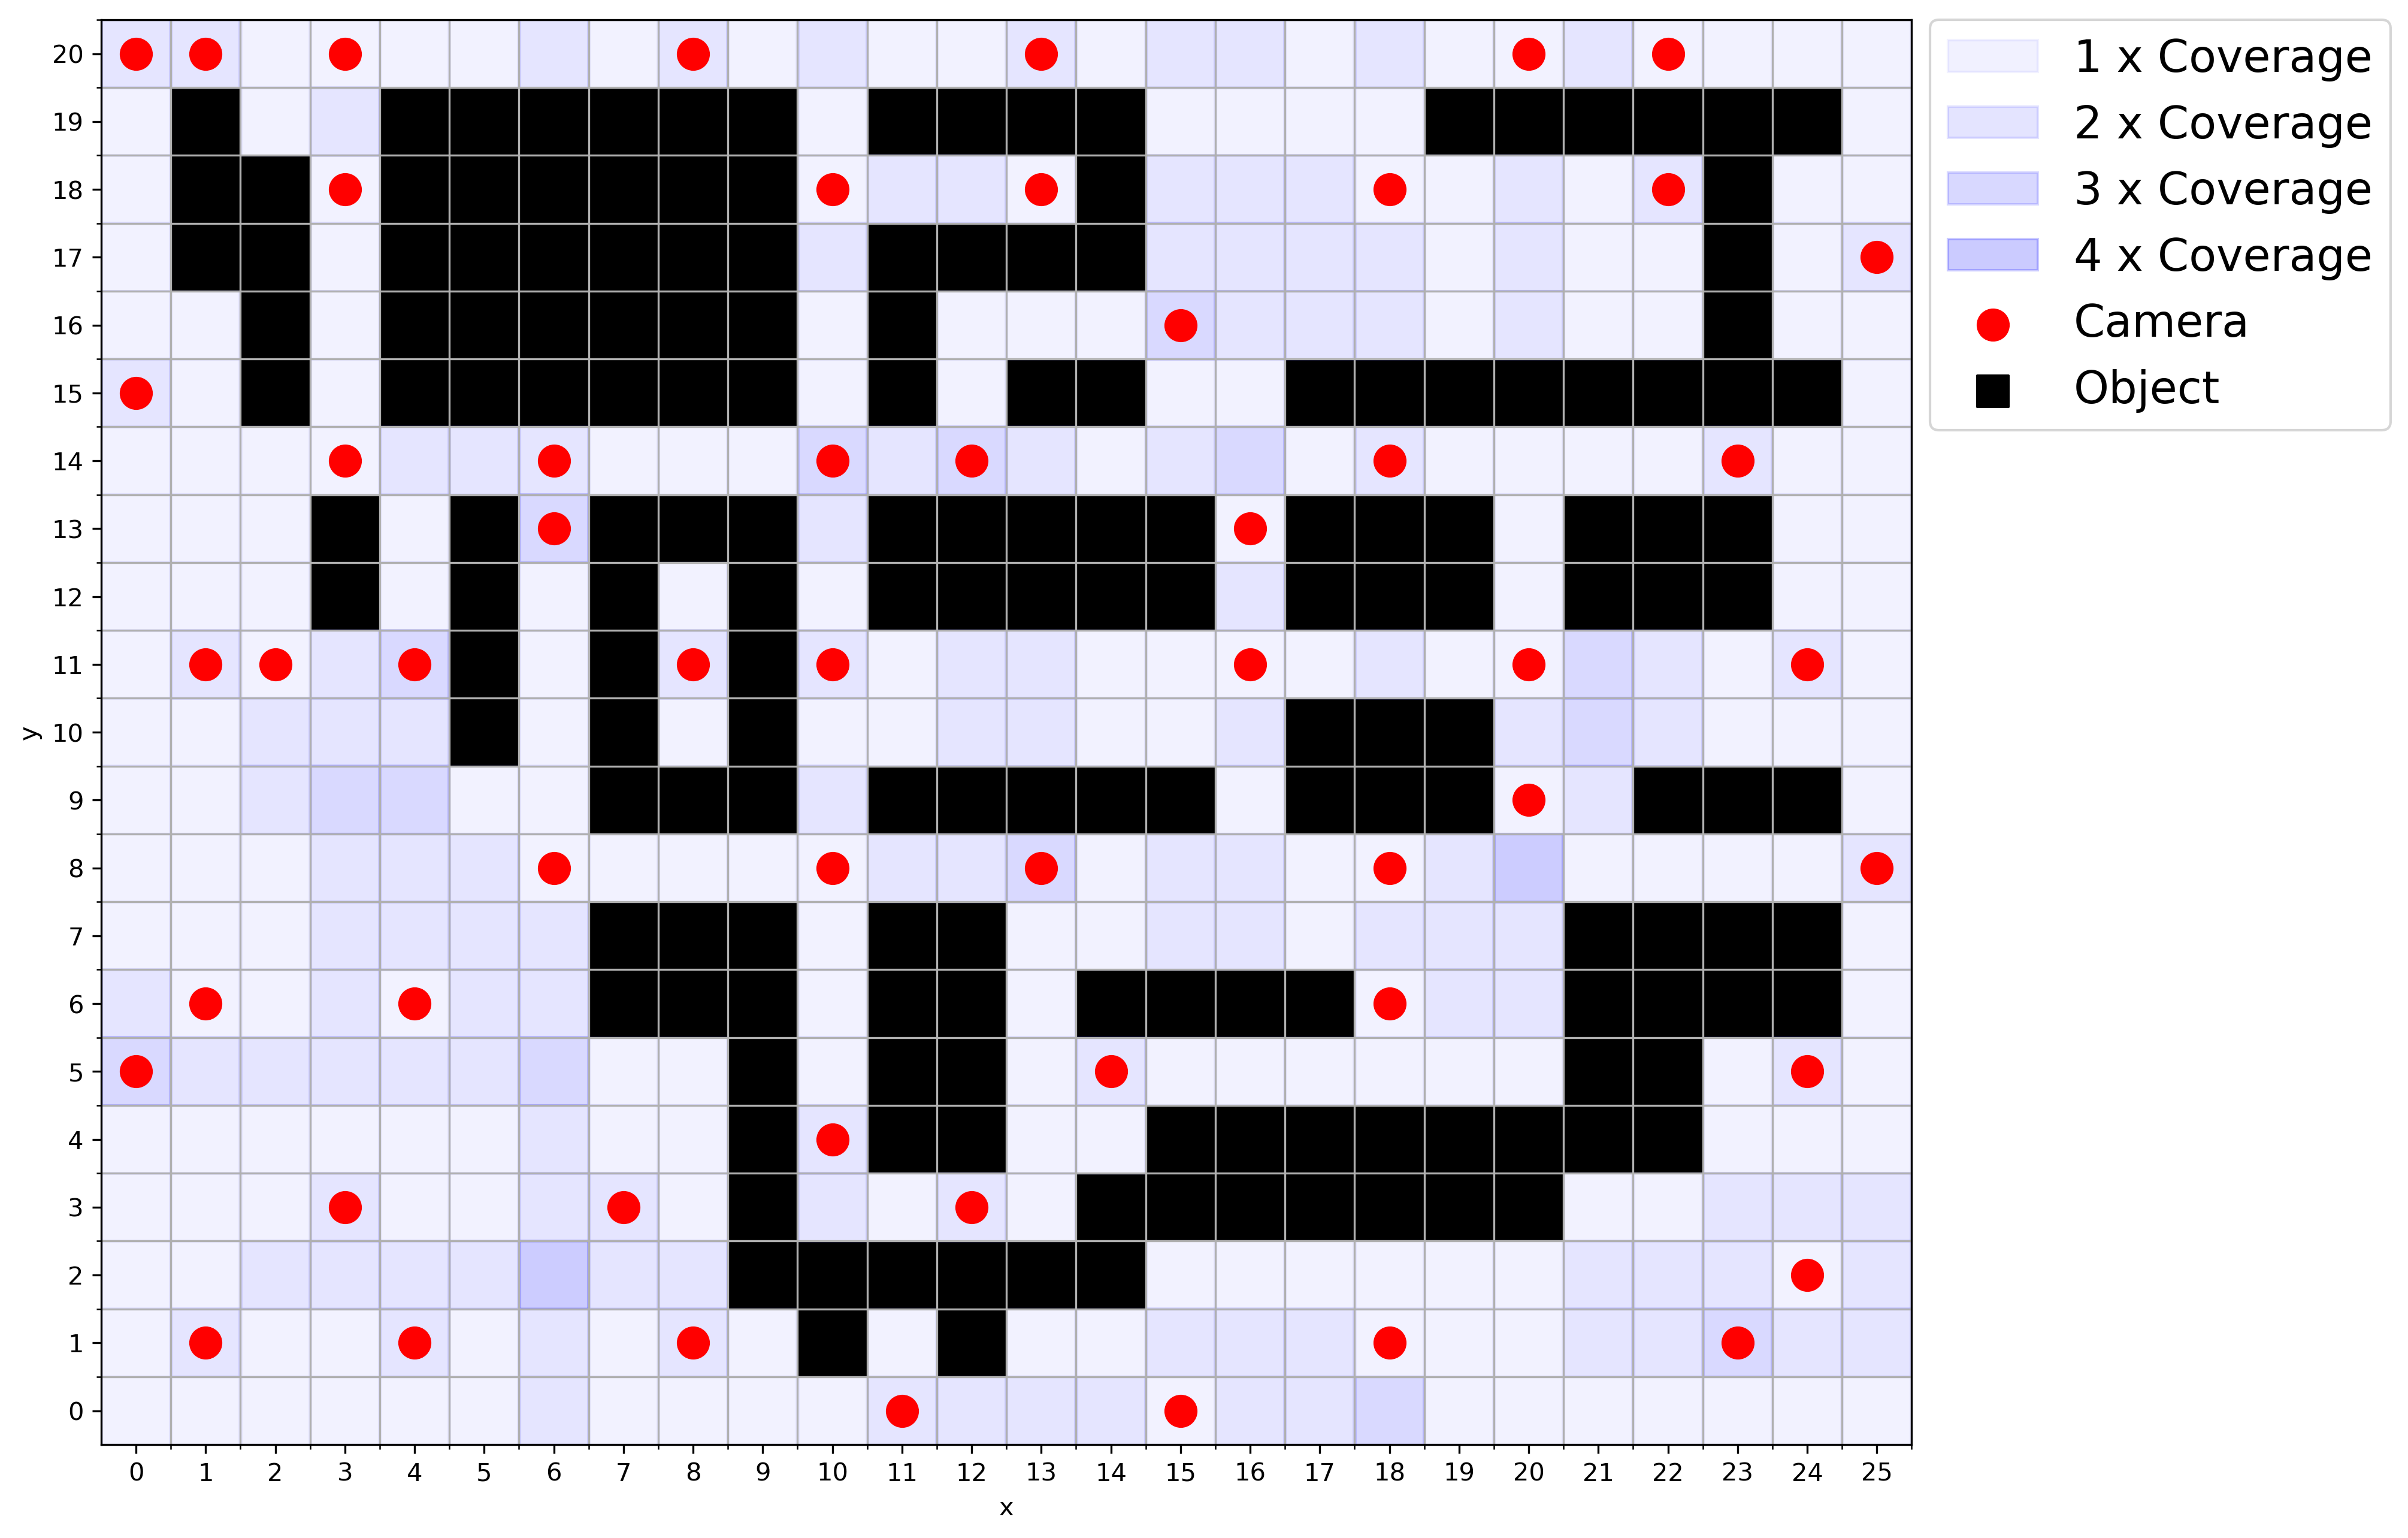

In [4]:
if satcheck == sat:
	m = s.model()
	model = ['%s = %s' % (d.name(), m[d]) for d in m.decls()]
	model.sort()
	print ('\n=======================================================')
	print ('		PROBLEM: SATISFIABLE				    ')
	print ('=======================================================')
	print ('Map:', mapchoice)
	print ('Number of cameras:', numcams)
	print ('Cover level:', coverlevel)
	print ('Total computation time :',np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
	print ('Pre-calculation time:', np.floor(precalctime/60),'m',precalctime%60,'s')
	print ('Constraint generation :', np.floor(constrainttime/60), 'm', constrainttime%60, 's')

	print('Solver runtime :', np.floor(solvertime/60), 'm', solvertime%60,'s')
	if modeltoterminal == True:
		print('\n=======================================================')
		print('		MODEL:		    ')
		print('=======================================================')
		pp(model)
	if modeltxt == True:
		modeltxtfile = open("modelvalues.txt","w")
		modeltxtfile.write('=============================================\n')
		modeltxtfile.write('		MODEL RESULT					\n')
		modeltxtfile.write('=============================================\n')
		for m in model:
			modeltxtfile.write(str(m))
			modeltxtfile.write('\n')
		modeltxtfile.close()
else:
	print('\n=======================================================')
	print('		PROBLEM: INFEASIBLE				    ')
	print('=======================================================')
	print ('Map:', mapchoice)
	print ('Number of cameras:', numcams)
	print ('Cover level:', coverlevel)
	print('Total computation time :',np.floor((constrainttime+solvertime+precalctime)/60), 'm', (constrainttime+solvertime+precalctime)%60 , 's')
	print('Pre-calculation time:', np.floor(precalctime/60),'m',precalctime%60,'s')
	print('Constraint generation :', np.floor(constrainttime/60), 'm', constrainttime%60, 's')

if satcheck == sat:
	#parses model strings for camera locations, works because of alphabetized variable names...
    cams = []
    for pt in locations:
        if m.evaluate(C[pt[0]][pt[1]]):
            cams.append(pt)

scale = 2
#create plot object
datamap = plt.figure(figsize=(xgrid/scale,ygrid/scale), dpi = 300)
#create subplot layer for objects and gridlines
ax = datamap.add_subplot(111)

#Set x and y axis markers
xaxis = range(0,xgrid)
yaxis = range(0,ygrid)
plt.xticks(xaxis)
plt.yticks(yaxis)

#plot squares where objects are
#creates list of squares with one for each object
obstacles = []

for i in range(numobjects):
	objmap = patches.Rectangle((O[i][0]-0.5,O[i][1]-0.5), 1, 1)
	obstacles.append(objmap)
obstaclesquares = PatchCollection(obstacles, facecolor = 'black', label = 'Object')
ax.add_collection(obstaclesquares)

#set plot limits so all of the boxes are visible
plt.ylim(-0.5,ygrid-0.5)
plt.xlim(-0.5,xgrid-0.5)

textsize = 100
alphaval = 0.05
heatmap = np.zeros((xgrid,ygrid))
if satcheck == sat:
    Camlocs = np.array(cams)
    for loc in Camlocs:
        for el in l[loc[0]][loc[1]]:
            heatmap[el[0],el[1]] += 1
    for loc in locations:
        ax.scatter(loc[0],loc[1], c = 'blue', marker = 's', s = 740, alpha = heatmap[loc[0],loc[1]]*alphaval)
        #plt.scatter(C[i][0],C[i][1], marker = '$C%s$' % (i+1), s = textsize)
    camplots = ax.scatter(Camlocs[:,0],Camlocs[:,1], c = 'red', marker = 'o',s=150, label='Camera')
    


#plot where the objects are with white O#'s on top of the black square
#for i in range(numobjects):
Objlocs = np.array(O)
objplots = ax.scatter(Objlocs[:,0],Objlocs[:,1], marker = 's', s = 150, color = 'black', label='Object')

handlelist = []
for i in range(int(np.max(heatmap))):
    handlelist += [patches.Patch(color='blue',alpha=(i+1)*alphaval,label=('%s x Coverage' % (i+1)))]
handlelist += [camplots]
handlelist += [objplots]
#create gridlines in the correct locations
minor_locatorx = AutoMinorLocator(2)
minor_locatory = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locatorx)
ax.yaxis.set_minor_locator(minor_locatory)
plt.grid(which='minor')
plt.xlabel('x')
plt.ylabel('y')
ax.legend(handles=handlelist,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,fontsize=18)
#plt.tight_layout()
plt.savefig('thisone.png')
plt.show()

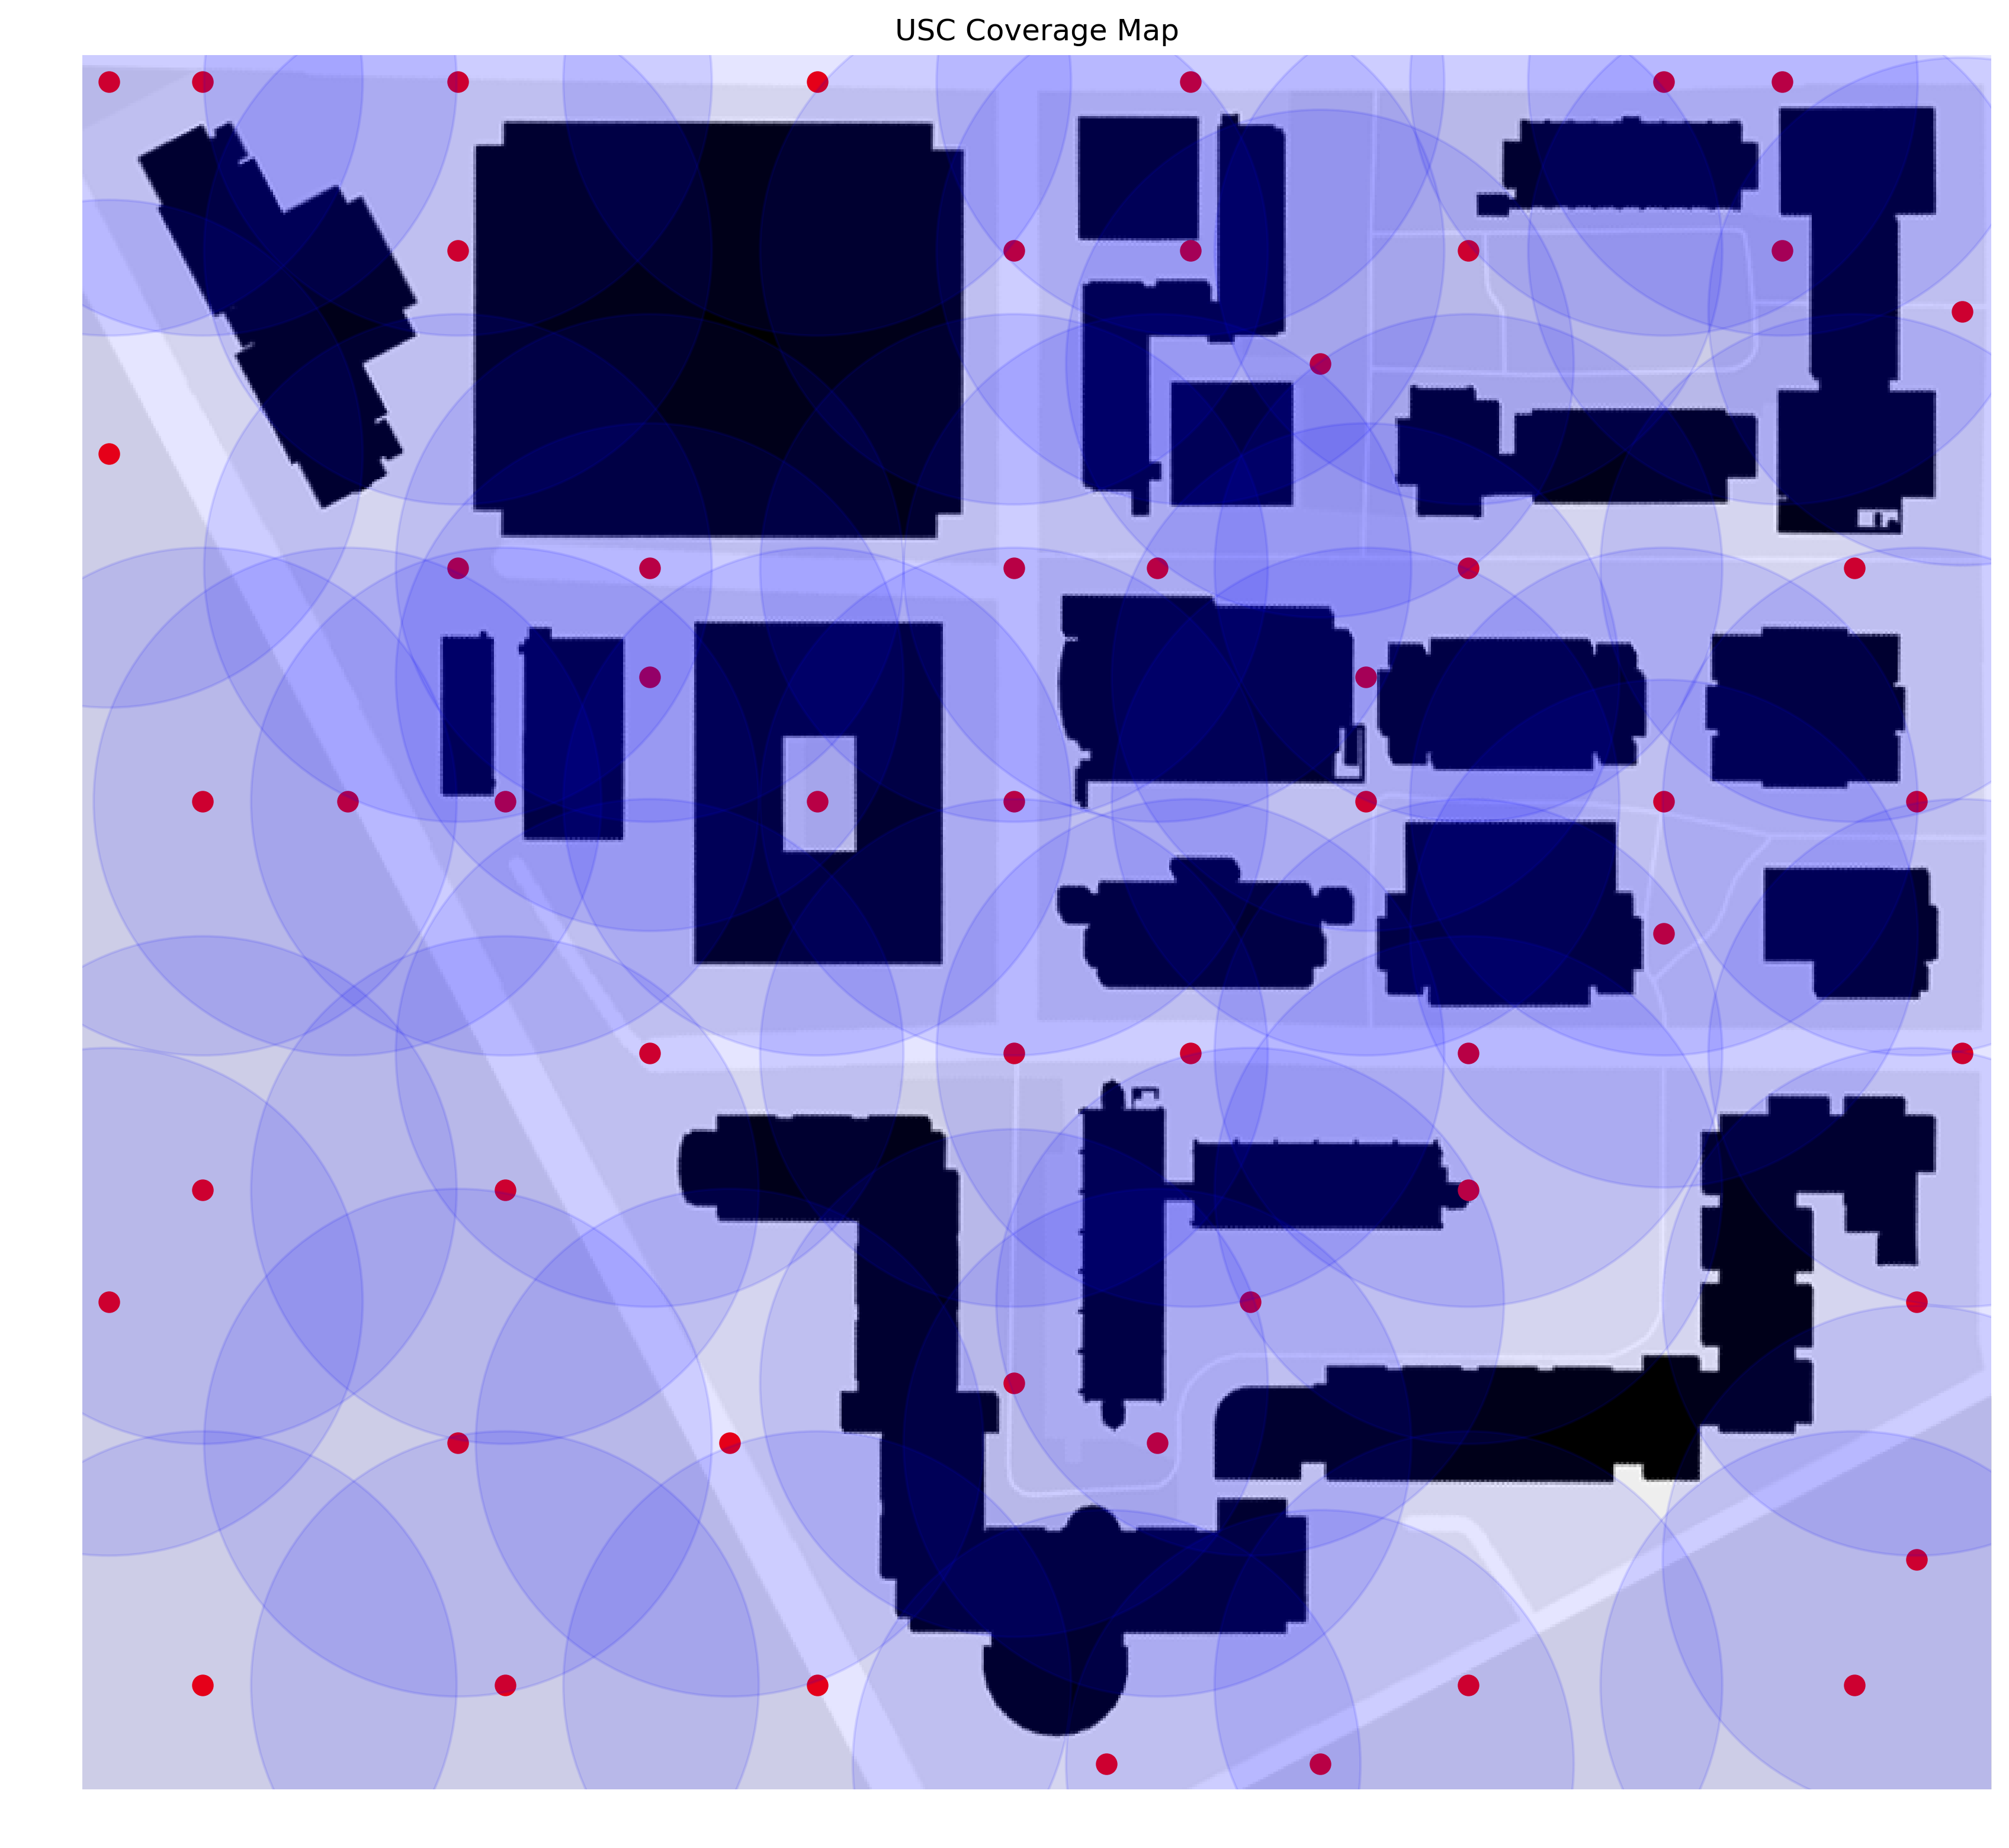

In [5]:
pixels = []
circles = []
for cam in Camlocs:
    pixelx = np.sum(Costs[0:cam[0],0,0]) + Costs[cam[0],0,0]/2.0
    pixely = np.sum(Costs[0,cam[1]:ygrid+1,1]) - Costs[0,cam[1],1]/2.0
    pixels.append([pixelx,pixely])    
    circles.append(plt.Circle((pixelx,pixely), allow, color = 'b', alpha = 0.1))
pixels = np.array(pixels)
if USCmap == True:
    im = plt.imread('USCEngineeringMap.png')
    picscale=2.0
    pic = plt.figure(figsize=(xgrid/picscale,ygrid/picscale),dpi=300)
    picplt = pic.add_subplot(111)
    implot = picplt.imshow(im)
    for circ in circles:
        picplt.add_artist(circ)
    picplt.scatter(pixels[:,0],pixels[:,1], c='red',marker='o',s=60,label='Cameras')
    plt.axis('off')
    plt.title('USC Coverage Map')
    plt.tight_layout()
    plt.savefig('USCCoverageMap.png')
    plt.show()
elif UCLAmap == True:
    im = plt.imread('UCLAEngineeringMap.png')
    picscale=2.0
    pic = plt.figure(figsize=(xgrid/picscale,ygrid/picscale),dpi=300)
    picplt = pic.add_subplot(111)
    implot = picplt.imshow(im)
    for circ in circles:
        picplt.add_artist(circ)
    picplt.scatter(pixels[:,0],pixels[:,1], c='red',marker='o',s=60,label='Cameras')
    plt.axis('off')
    plt.title('UCLA Coverage Map')
    plt.tight_layout()
    plt.savefig('UCLACoverageMap.png')
    plt.show()
elif ARLmap == True:
    im = plt.imread('ARLMap.png')
    picscale=2.0
    pic = plt.figure(figsize=(xgrid/picscale,ygrid/picscale),dpi=300)
    picplt = pic.add_subplot(111)
    implot = picplt.imshow(im)
    for circ in circles:
        picplt.add_artist(circ)
    picplt.scatter(pixels[:,0],pixels[:,1], c='red',marker='o',s=60,label='Cameras')
    plt.axis('off')
    plt.title('ARL Coverage Map')
    plt.tight_layout()
    plt.savefig('ARLCoverageMap.png')
    plt.show()
elif GTmap == True:
    im = plt.imread('GTMap.png')
    picscale=2.0
    pic = plt.figure(figsize=(xgrid/picscale,ygrid/picscale),dpi=300)
    picplt = pic.add_subplot(111)
    implot = picplt.imshow(im)
    for circ in circles:
        picplt.add_artist(circ)
    picplt.scatter(pixels[:,0],pixels[:,1], c='red',marker='o',s=60,label='Cameras')
    plt.axis('off')
    plt.title('ARL Coverage Map')
    plt.tight_layout()
    plt.savefig('ARLCoverageMap.png')
    plt.show()
